# Problem Statement

## Option 2: Develop a NLP solution to understand the meaning of a sentence in a specific context.


The purpose of this notebook is to build a machine learning model that could analyse the sentiment of a movie review sentence.

Data source: https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews



In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Step1: Model training


In [5]:
df = pd.read_csv('sentiment-analysis-on-movie-reviews/train.tsv.zip', sep='\t')

In [6]:
df

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
...,...,...,...,...
156055,156056,8544,Hearst 's,2
156056,156057,8544,forced avuncular chortles,1
156057,156058,8544,avuncular chortles,3
156058,156059,8544,avuncular,2


In [9]:
print(f"Before dedup, data samples={df.shape}")
df.drop_duplicates('Phrase', inplace=True)
print(f"After dedup, data samples={df.shape}")

Before dedup, data samples=(156060, 4)
After dedup, data samples=(156060, 4)


In [26]:
mapp_sent = {0: 'negative',
             1: 'somewhat negative',
             2: 'neutral',
             3: 'somewhat positive',
             4: 'positive'}

df['label'] = df['Sentiment'].apply(lambda x:mapp_sent[x])

In [116]:
def autolabel_base(rects, ax):
    
    for rect in rects:
        x_value = rect.get_width() + 2000
        y_value = rect.get_y() + rect.get_height() / 2
        
        ax.text(x_value, y_value, '%d'%int(x_value),
                ha='center', fontsize=12)

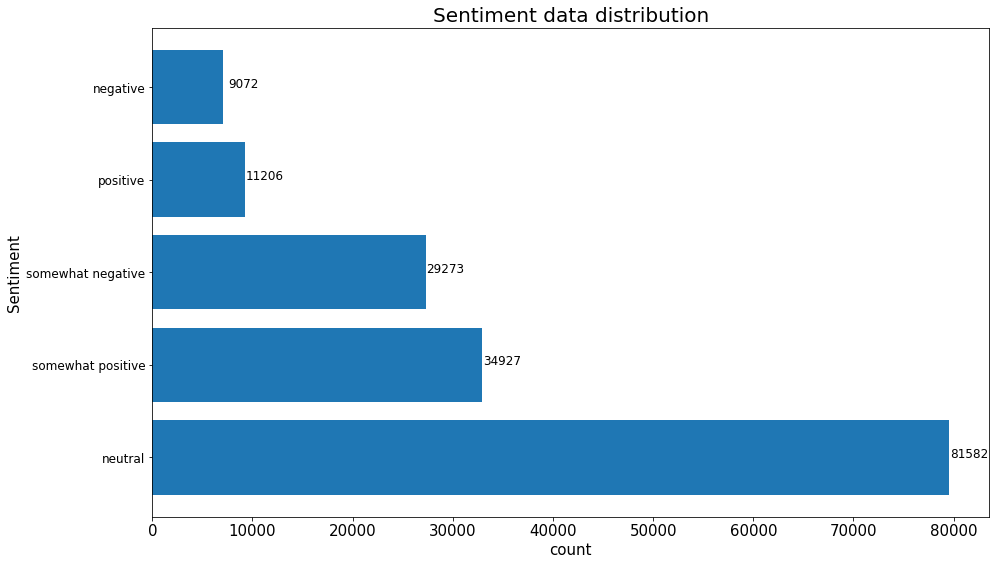

In [117]:
plt.figure(figsize=(15,9))
rects = plt.barh(df.value_counts('label').reset_index()['label'], df.value_counts('label').reset_index()[0])
plt.title('Sentiment data distribution', fontsize=20)
plt.xlabel('count', fontsize=15)
plt.ylabel('Sentiment', fontsize=15)
plt.yticks(fontsize=12)
plt.xticks(fontsize=15)

autolabel_base(rects, plt)

# Preprocessing & cleaning

## Model#1: Classic model

In [5]:
from nltk.tokenize import word_tokenize
from string import punctuation
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from string import punctuation
import re
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV

In [6]:
# Helper functions


ps = PorterStemmer()
negation_list = ["arent","isnt","dont","doesnt","not","cant","couldnt", "werent",
                 "wont","didnt","never","nothing","nowhere","noone","none"
                "hasnt","hadnt","shouldnt","wouldnt","aint"]
stops_lst = stopwords.words('english')
stops_lst.extend(['film', 'movie'])           
    
def preProcess(sentence):
    sentence = sentence.lower()
    sentence = re.sub('n[^A-Za-z ]t','nt', sentence)
    sentence = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', '', sentence)
    sentence = re.sub('@[^\s]+', '', sentence)
    sentence = re.sub(r'#([^\s]+)', r'\1', sentence)
    sentence = word_tokenize(sentence)
    clean_list = [];
    negate = False
    for word in sentence:
        word = ps.stem(word)
        if word in negation_list:
            negate = True
        elif negate is True and word in list(punctuation):
            negate = False
            
        if negate and word not in negation_list:
            word = "not_"+word
        else:
            pass
        word = re.sub('[^A-Za-z_ ]+', '', word)
        if len(word) > 2 and word not in stops_lst:
            clean_list.append(word)
    clean_set = set(clean_list)
    return " ".join(clean_set)

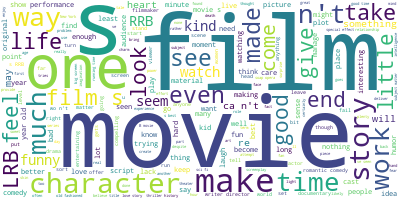

In [6]:
# Wordcloud before preprocess

# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(df['Phrase'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()


In [7]:
df.shape

(156060, 4)

In [8]:
# Example result after applying preprocessing

print(f"""
    original sentence: \n\t\t{df['Phrase'].iloc[0]}
    sentence after preprocess: \n\t\t{preProcess(df['Phrase'].iloc[0])}
    """)


    original sentence: 
		A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .
    sentence after preprocess: 
		gander amount goos occasion adag escapad seri good demonstr none also amus much stori
    


In [9]:

df = df.drop_duplicates(subset='Phrase')
df['Phrase'] = df['Phrase'].apply(preProcess)

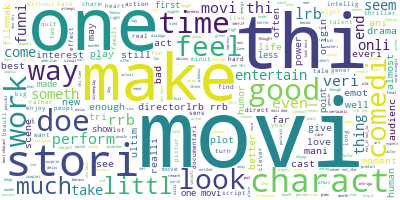

In [10]:
# Wordcloud before preprocess

# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(df['Phrase'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()


In [11]:
df.shape

(156060, 4)

In [12]:
# train-test split

X_train, X_test, y_train, y_test = train_test_split(df['Phrase'], df['Sentiment'],
                                                    test_size=0.2,
                                                    random_state=40,
                                                    stratify=df['Sentiment']
                                                   )


In [13]:
print(f'''
    training size: {X_train.shape[0]},
    testing size: {X_test.shape[0]}
    ''')


    training size: 124848,
    testing size: 31212
    


# Start building classifier model

## Model #1: TFIDF + MNB

In [14]:
## Base line model

pipeline = Pipeline([
    ('vect', TfidfVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('classifier', MultinomialNB()),
])


In [15]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('vect', TfidfVectorizer()), ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [16]:
y_pred = pipeline.predict(X_test)

In [17]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.51      0.04      0.07      1414
           1       0.52      0.28      0.37      5455
           2       0.61      0.89      0.72     15917
           3       0.53      0.37      0.44      6585
           4       0.58      0.06      0.12      1841

    accuracy                           0.59     31212
   macro avg       0.55      0.33      0.34     31212
weighted avg       0.57      0.59      0.53     31212



In [18]:
## GridSearch technique to improve accuracy 

In [19]:
parameters = {
    'vect__encoding': ['latin-1'],
    'vect__lowercase': [True],
    'vect__stop_words': ['english'],
}

grid = GridSearchCV(pipeline, parameters, n_jobs=-1, cv=10, scoring='accuracy')

In [20]:
grid.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('vect', TfidfVectorizer()),
                                       ('tfidf', TfidfTransformer()),
                                       ('classifier', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'vect__encoding': ['latin-1'],
                         'vect__lowercase': [True],
                         'vect__stop_words': ['english']},
             scoring='accuracy')

In [21]:
print(f'''
    Gridsearch best score: {grid.best_score_},
    best parameters: \n\t\t{grid.best_params_},
    best estimator: \n\t\t{grid.best_estimator_}
    ''')


    Gridsearch best score: 0.5836377122588761,
    best parameters: 
		{'vect__encoding': 'latin-1', 'vect__lowercase': True, 'vect__stop_words': 'english'},
    best estimator: 
		Pipeline(steps=[('vect',
                 TfidfVectorizer(encoding='latin-1', stop_words='english')),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])
    


In [22]:
y_pred = grid.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.53      0.04      0.08      1414
           1       0.52      0.28      0.37      5455
           2       0.61      0.89      0.72     15917
           3       0.52      0.37      0.43      6585
           4       0.59      0.07      0.12      1841

    accuracy                           0.59     31212
   macro avg       0.55      0.33      0.34     31212
weighted avg       0.57      0.59      0.53     31212



The result still not satisfactory, trying to use different embedding 

## Model #2: BOW + MNB

In [25]:
pipeline = Pipeline([
   ( 'bow',CountVectorizer()),
    ('classifier',MultinomialNB()),
])

In [26]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('bow', CountVectorizer()), ('classifier', MultinomialNB())])

In [27]:
y_pred = pipeline.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.45      0.26      0.33      1414
           1       0.51      0.40      0.45      5455
           2       0.67      0.81      0.73     15917
           3       0.51      0.47      0.49      6585
           4       0.47      0.26      0.33      1841

    accuracy                           0.61     31212
   macro avg       0.52      0.44      0.47     31212
weighted avg       0.59      0.61      0.59     31212



In [28]:
parameters = {
    'bow__encoding': ['latin-1'],
    'bow__lowercase': [True],
    'bow__stop_words': ['english'],
}

grid = GridSearchCV(pipeline, parameters, n_jobs=-1, cv=10, scoring='accuracy')

In [29]:
grid.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('bow', CountVectorizer()),
                                       ('classifier', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'bow__encoding': ['latin-1'], 'bow__lowercase': [True],
                         'bow__stop_words': ['english']},
             scoring='accuracy')

In [30]:
print(f'''
    Gridsearch best score: {grid.best_score_},
    best parameters: \n\t\t{grid.best_params_},
    best estimator: \n\t\t{grid.best_estimator_}
    ''')


    Gridsearch best score: 0.6078511509550005,
    best parameters: 
		{'bow__encoding': 'latin-1', 'bow__lowercase': True, 'bow__stop_words': 'english'},
    best estimator: 
		Pipeline(steps=[('bow',
                 CountVectorizer(encoding='latin-1', stop_words='english')),
                ('classifier', MultinomialNB())])
    


In [31]:
y_pred = grid.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.46      0.26      0.33      1414
           1       0.52      0.39      0.45      5455
           2       0.67      0.81      0.73     15917
           3       0.51      0.47      0.49      6585
           4       0.47      0.25      0.33      1841

    accuracy                           0.61     31212
   macro avg       0.53      0.44      0.47     31212
weighted avg       0.59      0.61      0.59     31212



## Model#3: BOW + Random Forest



In [32]:
from sklearn.ensemble import RandomForestClassifier
pipeline = Pipeline([
   ('bow',CountVectorizer(max_features=3000)),
   ('classifier',RandomForestClassifier(n_estimators=100,criterion='gini',random_state=42)),
])

In [33]:
pipeline.fit(X_train, y_train)
 
y_pred = pipeline.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.47      0.37      0.42      1414
           1       0.55      0.43      0.48      5455
           2       0.70      0.82      0.76     15917
           3       0.56      0.49      0.52      6585
           4       0.49      0.37      0.42      1841

    accuracy                           0.64     31212
   macro avg       0.55      0.50      0.52     31212
weighted avg       0.62      0.64      0.62     31212



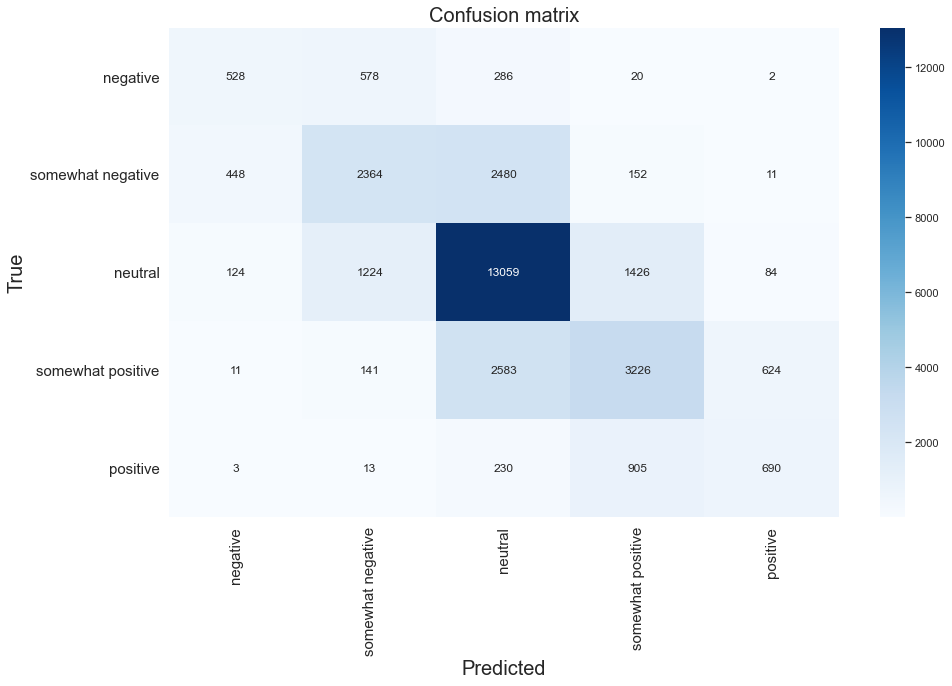

In [62]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

labels = ['negative',
          'somewhat negative',
          'neutral',
          'somewhat positive',
          'positive']

cm = confusion_matrix(y_test, y_pred)

import seaborn as sns
sns.set()
plt.figure(figsize = (15,9))
sns.heatmap(cm, annot=True, cmap=plt.cm.Blues, fmt='d')
plt.xticks([x+0.5 for x in range(len(labels))], labels,  rotation=90, fontsize=15)
plt.yticks([x+0.5 for x in range(len(labels))], labels, rotation=0, fontsize=15)
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('True', fontsize=20)
plt.title("Confusion matrix", fontsize=20)
plt.show()

In [63]:
import pickle
pickle.dump(pipeline,open("../models/rf.pkl","wb"))

# Further improvement

1. Using deep learning, with Transformers models it can achieve around 75% accuracy from [this notebook](https://www.kaggle.com/maroberti/fastai-with-transformers-bert-roberta)
2. Train word embedding on our own - To make sure the data can be more specified to this case
3. Sampling method like SMOTE to be implement as class 2 is having much data points

-- END --

# Examining

In [35]:
examine_df = pd.DataFrame({'Phrases':X_test, 'label': y_test, 'predicted label':y_pred})

In [36]:
examine_df[examine_df['label']!=examine_df['predicted label']]

,Phrases,label,predicted label
59487,line stage impress crackl hardwar,3,2
12825,incomprehens ann rice novel,1,2
101493,dozen guy bad,1,2
97444,question intrigu,2,3
155153,human stori spirit determin move,4,3
...,...,...,...
136374,absurd twist idiot court plot maneuv,1,0
77903,gener,1,2
125159,consol anyon begrudg whatev receiv,1,2
10648,center anywher get near stori,2,3


In [1]:
import pickle

loaded_model = pickle.load(open("../models/rf.pkl", 'rb'))

In [10]:
loaded_model.predict([preProcess('worst movie ever')])[0]

0